from https://keras.io/examples/generative/vae/

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from progressbar import progressbar as pbar
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [89]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean_layer = layers.Dense(latent_dim, name="z_mean")
z_mean = z_mean_layer(x)

z_log_var_layer = layers.Dense(latent_dim, name="z_log_var")
z_log_var = z_log_var_layer(x)

z_layer = Sampling()
z = z_layer([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


eps (None, 2)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                              

In [22]:
z_mean_layer.weights

[<tf.Variable 'z_mean/kernel:0' shape=(16, 2) dtype=float32, numpy=
 array([[ 0.3494475 , -0.5748344 ],
        [-0.5002281 ,  0.353023  ],
        [ 0.38622373, -0.21083307],
        [-0.22516707,  0.3665325 ],
        [-0.39301062, -0.5423585 ],
        [ 0.4325416 ,  0.4787346 ],
        [-0.10220465,  0.44986832],
        [ 0.13890696, -0.2279585 ],
        [ 0.00528896, -0.49983856],
        [-0.570476  ,  0.13780713],
        [ 0.02023166,  0.35009927],
        [-0.28937742,  0.5311872 ],
        [ 0.24010468,  0.15951246],
        [ 0.5573343 ,  0.38312423],
        [-0.03501785,  0.4335518 ],
        [ 0.51029086, -0.4053787 ]], dtype=float32)>,
 <tf.Variable 'z_mean/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [136]:
N = 100000
xm, xv = [np.random.random(size=(1,2))*10, np.random.random(size=(1,2))]
print ("xm", xm)
print ("xv", xv)
xm, xv = np.r_[list(xm)*N], np.r_[list(xv)*N]


xm [[0.79527035 7.08865147]]
xv [[0.88145698 0.22796039]]


In [137]:
xs = z_layer([xm, xv]).numpy()
xs.shape

eps (100000, 2)


(100000, 2)

In [138]:
print ("mean", xs.mean(axis=0))
print ("std ", np.log(xs.std(axis=0))*2)

mean [0.79073054 7.088456  ]
std  [0.88463134 0.2361723 ]


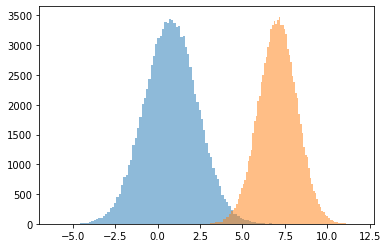

In [139]:
plt.hist(xs[:,0], bins=100, alpha=.5);
plt.hist(xs[:,1], bins=100, alpha=.5);

In [14]:
tf.keras.backend.set_value(
    z_mean,
    [[0,1]]
)

AttributeError: 'KerasTensor' object has no attribute 'assign'

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 6s 1us/step
Epoch 1/30


2021-12-30 22:33:17.954588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-30 22:33:20.095485: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


547/547 [==============================] - 12s 11ms/step - loss: 256.2279 - reconstruction_loss: 206.6370 - kl_loss: 2.6425
Epoch 2/30
547/547 [==============================] - 5s 10ms/step - loss: 172.5689 - reconstruction_loss: 164.0686 - kl_loss: 4.6792
Epoch 3/30
547/547 [==============================] - 6s 11ms/step - loss: 163.5837 - reconstruction_loss: 157.3226 - kl_loss: 5.1551
Epoch 4/30
547/547 [==============================] - 5s 10ms/step - loss: 160.3602 - reconstruction_loss: 154.6984 - kl_loss: 5.3863
Epoch 5/30
547/547 [==============================] - 6s 11ms/step - loss: 158.6035 - reconstruction_loss: 153.0280 - kl_loss: 5.4697
Epoch 6/30
547/547 [==============================] - 5s 10ms/step - loss: 157.3546 - reconstruction_loss: 151.8448 - kl_loss: 5.5531
Epoch 7/30
547/547 [==============================] - 6s 12ms/step - loss: 156.4090 - reconstruction_loss: 150.9359 - kl_loss: 5.6084
Epoch 8/30
547/547 [==============================] - 6s 11ms/step - los

In [86]:
encoder(mnist_digits[:2])

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.00163442,  0.02812073],
        [-0.01177108,  0.02198686]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.05349901,  0.0179426 ],
        [-0.00972829,  0.00958709]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.28369024,  1.4477018 ],
        [-0.23252563,  0.18800986]], dtype=float32)>]

In [87]:
encoder(mnist_digits[:2])

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.00163442,  0.02812073],
        [-0.01177108,  0.02198686]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.05349901,  0.0179426 ],
        [-0.00972829,  0.00958709]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.5051576 ,  0.4592255 ],
        [-0.92985916, -0.92410475]], dtype=float32)>]

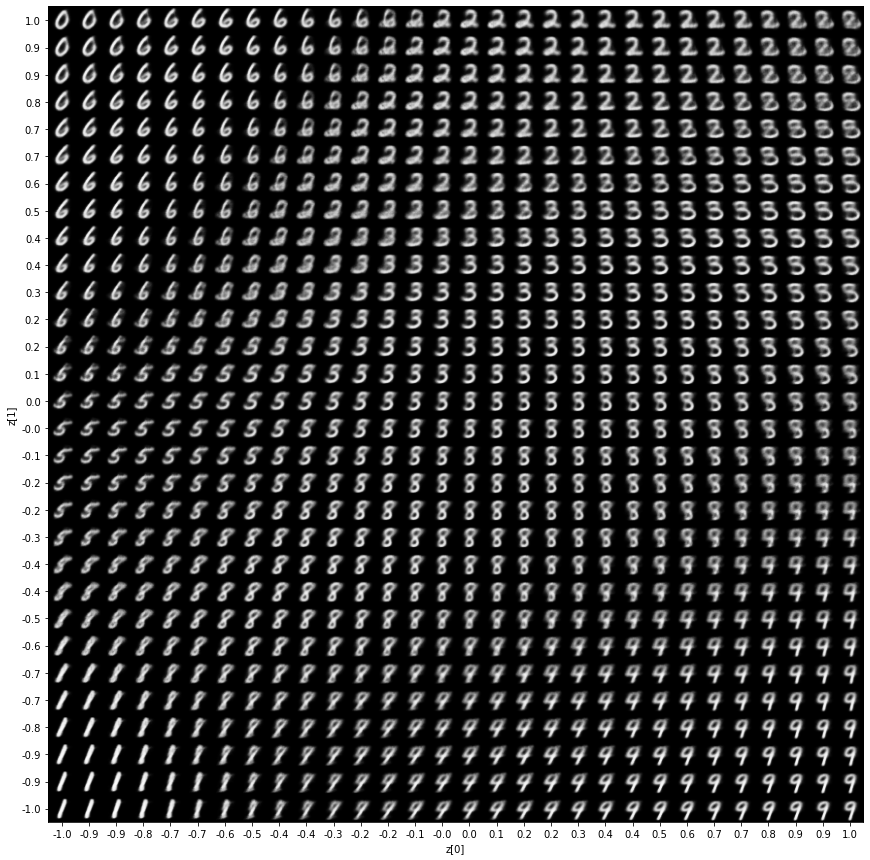

In [7]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

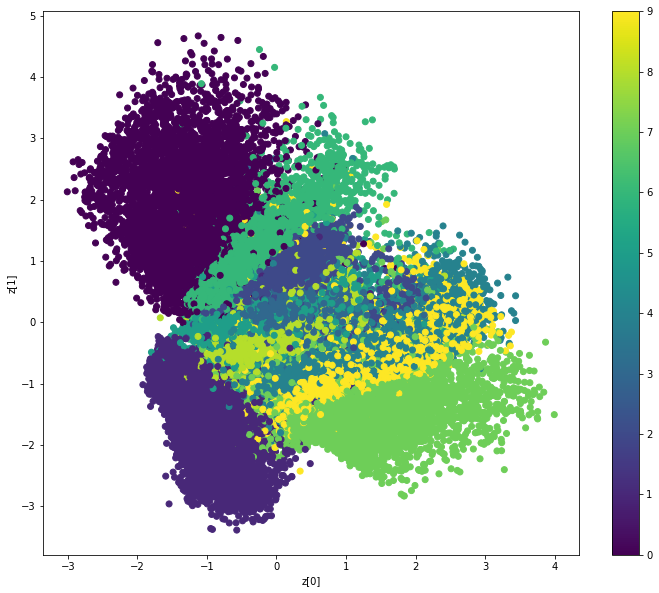

In [8]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)